<h1><div align="center">RNN for Timeseries</div></h1>
<div align="center">Bruno Gonçalves</div>
<div align="center"><a href="http://www.data4sci.com/">www.data4sci.com</a></div>
<div align="center">@bgoncalves</div>
<!--h2 align="center", style="font-size=150%">Part I</h2-->

In [1]:
import numpy as np
np.random.seed(123)

import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf
tf.set_random_seed(1234)

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import watermark

%load_ext watermark
%matplotlib inline

Using TensorFlow backend.


Let's start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -p numpy,scipy,keras,matplotlib,sklearn,pandas

Tue Apr 16 2019 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
scipy 1.2.1
keras 2.2.4
matplotlib 3.0.3
sklearn 0.20.3
pandas 0.24.2

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.2.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


# Load dataset

In [3]:
X = np.arange(0, 360)
y = np.sin(X*np.pi/10)
dataset = pd.DataFrame({"X": X, "y":y})
dataset = dataset.set_index("X")

It's always important to see what you are doing. You can save a lot of time like this ;)

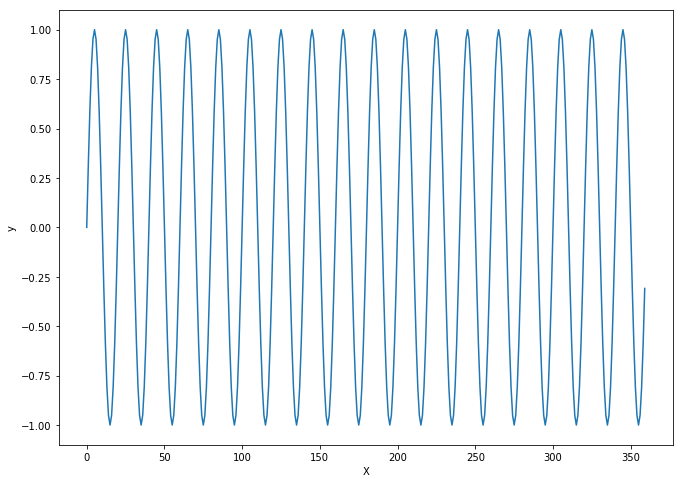

In [4]:
plt.plot(dataset)
plt.xlabel('X')
plt.ylabel('y');
plt.gcf().set_size_inches(11,8)

## Training and Testing datasets 
The y values are just the next x value

In [5]:
values = dataset['y'].values.reshape(-1, 1)
X = values[:-1]
y = values[1:]

We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it.

In [6]:
n_points = len(values)
train_points = int(2/3*n_points)+1
X_train, X_test = X[:train_points], X[train_points:]
y_train, y_test = y[:train_points], y[train_points:]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 241 training points and 118 testing points


The SimpleRNN model expects a 3D ([samples, time steps, features]) dataset so we reshape them accordingly 

In [7]:
tf.reset_default_graph()
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(241, 1, 1)
(118, 1, 1)


We're only using one timestep

## Define the model architecture. 
We'll be using a SimpleRNN model with 4 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [8]:
X_test.shape

(118, 1, 1)

In [9]:
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [10]:
nb_epoch = 100

model.fit(X_train, y_train, epochs=nb_epoch)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
241/241 [==============================] - 1s 3ms/step - loss: 0.0534
Epoch 2/100
241/241 [==============================] - 0s 60us/step - loss: 0.0495
Epoch 3/100
241/241 [==============================] - 0s 61us/step - loss: 0.0484
Epoch 4/100
241/241 [==============================] - 0s 56us/step - loss: 0.0483
Epoch 5/100
241/241 [==============================] - 0s 63us/step - loss: 0.0485
Epoch 6/100
241/241 [==============================] - 0s 74us/step - loss: 0.0484
Epoch 7/100
241/241 [==============================] - 0s 67us/step - loss: 0.0484
Epoch 8/100
241/241 [==============================] - 0s 59us/step - loss: 0.0482
Epoch 9/100
241/241 [==============================] - 0s 59us/step - loss: 0.0483
Epoch 10/100
241/241 [==============================] - 0s 58us/step - loss: 0.0483
Epoch 11/100
241/241 [==============================] - 0s 63us/step - loss: 0.0482
Epoch 12/100
241/241 [================

241/241 [==============================] - 0s 63us/step - loss: 0.0483
Epoch 96/100
241/241 [==============================] - 0s 75us/step - loss: 0.0483
Epoch 97/100
241/241 [==============================] - 0s 64us/step - loss: 0.0482
Epoch 98/100
241/241 [==============================] - 0s 63us/step - loss: 0.0483
Epoch 99/100
241/241 [==============================] - 0s 72us/step - loss: 0.0482
Epoch 100/100
241/241 [==============================] - 0s 64us/step - loss: 0.0483


## Make predictions

In [11]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Compile the values

In [12]:
dataset['RNN_train_predict'] = 0
dataset['RNN_test_predict'] = 0
dataset.loc[1:train_points, 'RNN_train_predict'] = y_train_pred
dataset.loc[train_points+1:, 'RNN_test_predict'] = y_test_pred

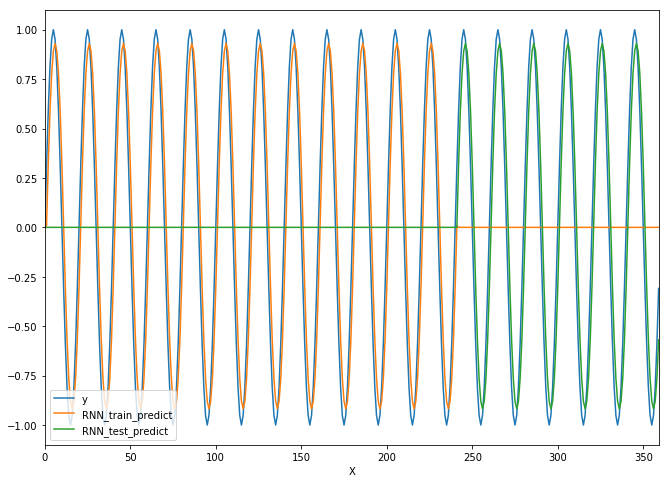

In [13]:
dataset[['y', 'RNN_train_predict', 'RNN_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

# LSTM
Let's now try using a slightly more sophisticated architecture

In [14]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [16]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
241/241 [==============================] - 2s 6ms/step - loss: 0.4593
Epoch 2/500
241/241 [==============================] - 0s 127us/step - loss: 0.4560
Epoch 3/500
241/241 [==============================] - 0s 132us/step - loss: 0.4528
Epoch 4/500
241/241 [==============================] - 0s 136us/step - loss: 0.4492
Epoch 5/500
241/241 [==============================] - 0s 123us/step - loss: 0.4456
Epoch 6/500
241/241 [==============================] - 0s 118us/step - loss: 0.4417
Epoch 7/500
241/241 [==============================] - 0s 119us/step - loss: 0.4376
Epoch 8/500
241/241 [==============================] - 0s 128us/step - loss: 0.4331
Epoch 9/500
241/241 [==============================] - 0s 146us/step - loss: 0.4286
Epoch 10/500
241/241 [==============================] - 0s 128us/step - loss: 0.4237
Epoch 11/500
241/241 [==============================] - 0s 111us/step - loss: 0.4185
Epoch 12/500
241/241 [==============================] - 0s 120us/step - loss

241/241 [==============================] - 0s 111us/step - loss: 0.0514
Epoch 98/500
241/241 [==============================] - 0s 112us/step - loss: 0.0513
Epoch 99/500
241/241 [==============================] - 0s 99us/step - loss: 0.0512
Epoch 100/500
241/241 [==============================] - 0s 112us/step - loss: 0.0511
Epoch 101/500
241/241 [==============================] - 0s 113us/step - loss: 0.0510
Epoch 102/500
241/241 [==============================] - 0s 116us/step - loss: 0.0509
Epoch 103/500
241/241 [==============================] - 0s 119us/step - loss: 0.0508
Epoch 104/500
241/241 [==============================] - 0s 140us/step - loss: 0.0507
Epoch 105/500
241/241 [==============================] - 0s 110us/step - loss: 0.0506
Epoch 106/500
241/241 [==============================] - 0s 108us/step - loss: 0.0506
Epoch 107/500
241/241 [==============================] - 0s 119us/step - loss: 0.0505
Epoch 108/500
241/241 [==============================] - 0s 112us/step 

241/241 [==============================] - 0s 123us/step - loss: 0.0493
Epoch 193/500
241/241 [==============================] - 0s 119us/step - loss: 0.0492
Epoch 194/500
241/241 [==============================] - 0s 114us/step - loss: 0.0492
Epoch 195/500
241/241 [==============================] - 0s 109us/step - loss: 0.0492
Epoch 196/500
241/241 [==============================] - 0s 109us/step - loss: 0.0492
Epoch 197/500
241/241 [==============================] - 0s 108us/step - loss: 0.0492
Epoch 198/500
241/241 [==============================] - 0s 110us/step - loss: 0.0492
Epoch 199/500
241/241 [==============================] - 0s 112us/step - loss: 0.0492
Epoch 200/500
241/241 [==============================] - 0s 110us/step - loss: 0.0492
Epoch 201/500
241/241 [==============================] - 0s 109us/step - loss: 0.0492
Epoch 202/500
241/241 [==============================] - 0s 125us/step - loss: 0.0492
Epoch 203/500
241/241 [==============================] - 0s 121us/st

241/241 [==============================] - 0s 93us/step - loss: 0.0491
Epoch 288/500
241/241 [==============================] - 0s 91us/step - loss: 0.0491
Epoch 289/500
241/241 [==============================] - 0s 93us/step - loss: 0.0491
Epoch 290/500
241/241 [==============================] - 0s 103us/step - loss: 0.0491
Epoch 291/500
241/241 [==============================] - 0s 104us/step - loss: 0.0491
Epoch 292/500
241/241 [==============================] - 0s 111us/step - loss: 0.0491
Epoch 293/500
241/241 [==============================] - 0s 105us/step - loss: 0.0491
Epoch 294/500
241/241 [==============================] - 0s 99us/step - loss: 0.0491
Epoch 295/500
241/241 [==============================] - 0s 102us/step - loss: 0.0491
Epoch 296/500
241/241 [==============================] - 0s 95us/step - loss: 0.0491
Epoch 297/500
241/241 [==============================] - 0s 106us/step - loss: 0.0491
Epoch 298/500
241/241 [==============================] - 0s 104us/step - 

241/241 [==============================] - 0s 97us/step - loss: 0.0489
Epoch 383/500
241/241 [==============================] - 0s 92us/step - loss: 0.0489
Epoch 384/500
241/241 [==============================] - 0s 95us/step - loss: 0.0489
Epoch 385/500
241/241 [==============================] - 0s 102us/step - loss: 0.0489
Epoch 386/500
241/241 [==============================] - 0s 99us/step - loss: 0.0489
Epoch 387/500
241/241 [==============================] - 0s 106us/step - loss: 0.0489
Epoch 388/500
241/241 [==============================] - 0s 101us/step - loss: 0.0489
Epoch 389/500
241/241 [==============================] - 0s 113us/step - loss: 0.0489
Epoch 390/500
241/241 [==============================] - 0s 117us/step - loss: 0.0489
Epoch 391/500
241/241 [==============================] - 0s 104us/step - loss: 0.0489
Epoch 392/500
241/241 [==============================] - 0s 101us/step - loss: 0.0489
Epoch 393/500
241/241 [==============================] - 0s 103us/step -

241/241 [==============================] - 0s 109us/step - loss: 0.0488
Epoch 478/500
241/241 [==============================] - 0s 111us/step - loss: 0.0488
Epoch 479/500
241/241 [==============================] - 0s 104us/step - loss: 0.0488
Epoch 480/500
241/241 [==============================] - 0s 102us/step - loss: 0.0488
Epoch 481/500
241/241 [==============================] - 0s 104us/step - loss: 0.0488
Epoch 482/500
241/241 [==============================] - 0s 100us/step - loss: 0.0488
Epoch 483/500
241/241 [==============================] - 0s 104us/step - loss: 0.0488
Epoch 484/500
241/241 [==============================] - 0s 112us/step - loss: 0.0488
Epoch 485/500
241/241 [==============================] - 0s 109us/step - loss: 0.0488
Epoch 486/500
241/241 [==============================] - 0s 108us/step - loss: 0.0488
Epoch 487/500
241/241 [==============================] - 0s 110us/step - loss: 0.0488
Epoch 488/500
241/241 [==============================] - 0s 109us/st

Calculate the predicted values

In [17]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['LSTM_train_predict'] = 0
dataset['LSTM_test_predict'] = 0
dataset.loc[1:train_points, 'LSTM_train_predict'] = y_train_pred
dataset.loc[train_points+1:, 'LSTM_test_predict'] = y_test_pred

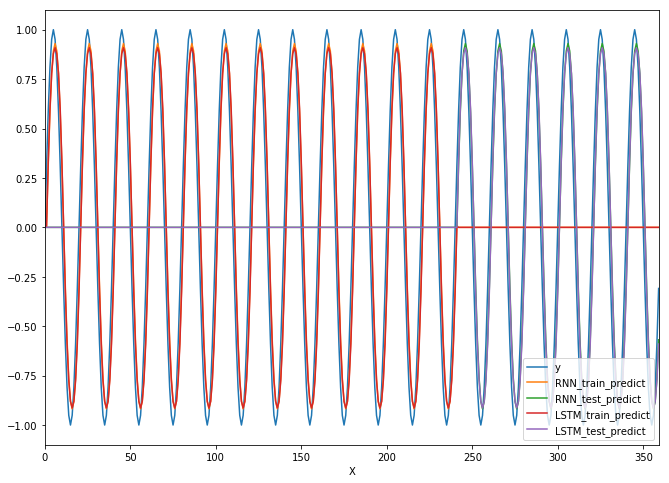

In [18]:
dataset[['y', 'RNN_train_predict', 'RNN_test_predict', 'LSTM_train_predict', 'LSTM_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

# Multiple timesteps
So far we've been using architectures with just a single timestep. Now we'll see how we can use multiple timesteps (t-1, t) to predict the value at t+1. We'll keep the basic architecture of the system. We still have the raw data in memory, so we don't need to reload it. We just have to be careful when we build the inputs

In [19]:
X2 = np.concatenate([X[0:-3], X[1:-2], X[2:-1]], axis=1)
y2 = X[3:]

X2_train, X2_test = X2[:train_points], X2[train_points:]
y2_train, y2_test = y2[:train_points], y2[train_points:]

print("We have", X2_train.shape[0], "training points and", X2_test.shape[0], "testing points")

We have 241 training points and 115 testing points


The more we increas the lag, the more points we lose! The rest of the code looks pretty much the same

In [20]:
tf.reset_default_graph()
keras.backend.clear_session()

X2_train = X2_train.reshape(X2_train.shape[0], X2_train.shape[1], 1)
X2_test = X2_test.reshape(X2_test.shape[0], X2_test.shape[1], 1)
print(X2_train.shape)
print(X2_test.shape)

(241, 3, 1)
(115, 3, 1)


But now we see that the result is slightly different. For each of our examples, we now have 3 timesteps to consider. Now we just need to refine the model:

In [21]:
model = Sequential()
model.add(LSTM(units=10, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [22]:
nb_epoch = 500
model.fit(X2_train, y2_train, epochs=nb_epoch, shuffle=False)

Epoch 1/500
241/241 [==============================] - 1s 5ms/step - loss: 0.3614
Epoch 2/500
241/241 [==============================] - 0s 199us/step - loss: 0.3414
Epoch 3/500
241/241 [==============================] - 0s 172us/step - loss: 0.3224
Epoch 4/500
241/241 [==============================] - 0s 170us/step - loss: 0.3044
Epoch 5/500
241/241 [==============================] - 0s 188us/step - loss: 0.2875
Epoch 6/500
241/241 [==============================] - 0s 198us/step - loss: 0.2715
Epoch 7/500
241/241 [==============================] - 0s 177us/step - loss: 0.2567
Epoch 8/500
241/241 [==============================] - 0s 187us/step - loss: 0.2429
Epoch 9/500
241/241 [==============================] - 0s 199us/step - loss: 0.2302
Epoch 10/500
241/241 [==============================] - 0s 232us/step - loss: 0.2189
Epoch 11/500
241/241 [==============================] - 0s 218us/step - loss: 0.2089
Epoch 12/500
241/241 [==============================] - 0s 198us/step - loss

241/241 [==============================] - 0s 200us/step - loss: 2.3239e-04
Epoch 97/500
241/241 [==============================] - 0s 202us/step - loss: 2.2787e-04
Epoch 98/500
241/241 [==============================] - 0s 203us/step - loss: 2.2362e-04
Epoch 99/500
241/241 [==============================] - 0s 215us/step - loss: 2.1960e-04
Epoch 100/500
241/241 [==============================] - 0s 221us/step - loss: 2.1580e-04
Epoch 101/500
241/241 [==============================] - 0s 230us/step - loss: 2.1218e-04
Epoch 102/500
241/241 [==============================] - 0s 215us/step - loss: 2.0873e-04
Epoch 103/500
241/241 [==============================] - 0s 193us/step - loss: 2.0543e-04
Epoch 104/500
241/241 [==============================] - 0s 216us/step - loss: 2.0226e-04
Epoch 105/500
241/241 [==============================] - 0s 203us/step - loss: 1.9922e-04
Epoch 106/500
241/241 [==============================] - 0s 203us/step - loss: 1.9628e-04
Epoch 107/500
241/241 [====

241/241 [==============================] - 0s 209us/step - loss: 6.4016e-05
Epoch 188/500
241/241 [==============================] - 0s 183us/step - loss: 6.3118e-05
Epoch 189/500
241/241 [==============================] - 0s 175us/step - loss: 6.2232e-05
Epoch 190/500
241/241 [==============================] - 0s 198us/step - loss: 6.1358e-05
Epoch 191/500
241/241 [==============================] - 0s 174us/step - loss: 6.0496e-05
Epoch 192/500
241/241 [==============================] - 0s 175us/step - loss: 5.9645e-05
Epoch 193/500
241/241 [==============================] - 0s 173us/step - loss: 5.8805e-05
Epoch 194/500
241/241 [==============================] - 0s 196us/step - loss: 5.7976e-05
Epoch 195/500
241/241 [==============================] - 0s 198us/step - loss: 5.7158e-05
Epoch 196/500
241/241 [==============================] - 0s 204us/step - loss: 5.6351e-05
Epoch 197/500
241/241 [==============================] - 0s 184us/step - loss: 5.5553e-05
Epoch 198/500
241/241 [=

241/241 [==============================] - 0s 219us/step - loss: 1.6493e-05
Epoch 279/500
241/241 [==============================] - 0s 208us/step - loss: 1.6255e-05
Epoch 280/500
241/241 [==============================] - 0s 209us/step - loss: 1.6021e-05
Epoch 281/500
241/241 [==============================] - 0s 215us/step - loss: 1.5791e-05
Epoch 282/500
241/241 [==============================] - 0s 205us/step - loss: 1.5565e-05
Epoch 283/500
241/241 [==============================] - 0s 197us/step - loss: 1.5344e-05
Epoch 284/500
241/241 [==============================] - 0s 193us/step - loss: 1.5127e-05
Epoch 285/500
241/241 [==============================] - 0s 180us/step - loss: 1.4913e-05
Epoch 286/500
241/241 [==============================] - 0s 178us/step - loss: 1.4704e-05
Epoch 287/500
241/241 [==============================] - 0s 177us/step - loss: 1.4499e-05
Epoch 288/500
241/241 [==============================] - 0s 177us/step - loss: 1.4297e-05
Epoch 289/500
241/241 [=

241/241 [==============================] - 0s 215us/step - loss: 6.7654e-06
Epoch 370/500
241/241 [==============================] - 0s 200us/step - loss: 6.7350e-06
Epoch 371/500
241/241 [==============================] - 0s 182us/step - loss: 6.7053e-06
Epoch 372/500
241/241 [==============================] - 0s 194us/step - loss: 6.6763e-06
Epoch 373/500
241/241 [==============================] - 0s 196us/step - loss: 6.6480e-06
Epoch 374/500
241/241 [==============================] - 0s 208us/step - loss: 6.6203e-06
Epoch 375/500
241/241 [==============================] - 0s 200us/step - loss: 6.5932e-06
Epoch 376/500
241/241 [==============================] - 0s 207us/step - loss: 6.5668e-06
Epoch 377/500
241/241 [==============================] - 0s 205us/step - loss: 6.5410e-06
Epoch 378/500
241/241 [==============================] - 0s 215us/step - loss: 6.5158e-06
Epoch 379/500
241/241 [==============================] - 0s 188us/step - loss: 6.4911e-06
Epoch 380/500
241/241 [=

241/241 [==============================] - 0s 204us/step - loss: 5.4899e-06
Epoch 461/500
241/241 [==============================] - 0s 204us/step - loss: 5.4829e-06
Epoch 462/500
241/241 [==============================] - 0s 213us/step - loss: 5.4759e-06
Epoch 463/500
241/241 [==============================] - 0s 232us/step - loss: 5.4688e-06
Epoch 464/500
241/241 [==============================] - 0s 191us/step - loss: 5.4618e-06
Epoch 465/500
241/241 [==============================] - 0s 190us/step - loss: 5.4550e-06
Epoch 466/500
241/241 [==============================] - 0s 176us/step - loss: 5.4481e-06
Epoch 467/500
241/241 [==============================] - 0s 180us/step - loss: 5.4412e-06
Epoch 468/500
241/241 [==============================] - 0s 193us/step - loss: 5.4344e-06
Epoch 469/500
241/241 [==============================] - 0s 192us/step - loss: 5.4275e-06
Epoch 470/500
241/241 [==============================] - 0s 214us/step - loss: 5.4206e-06
Epoch 471/500
241/241 [=

In [23]:
y_train_pred = model.predict(X2_train)
y_test_pred = model.predict(X2_test)

dataset['LSTM3_train_predict'] = 0
dataset['LSTM3_test_predict'] = 0
dataset.loc[3:train_points+2, 'LSTM3_train_predict'] = y_train_pred
dataset.loc[train_points+4:, 'LSTM3_test_predict'] = y_test_pred

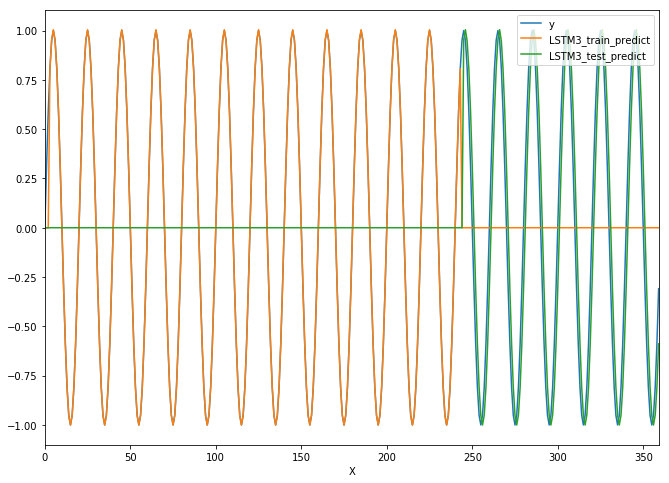

In [24]:
dataset[['y', #'RNN_train_predict', 'RNN_test_predict', 
                #'LSTM_train_predict', 'LSTM_test_predict', 
                'LSTM3_train_predict', 'LSTM3_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)